In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime
from skimage import measure

In [6]:
#path = '/nfs/twcroninlab002/tbeucler/ERA5/ERA5_LHF_SHF/2000/'
path = '/users/davidle/scratch/PW/2016/' #Path for Daint

In [7]:
PW = xr.open_mfdataset(path+'??PW.nc')

/users/davidle/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/opt/python/3.6.5.1/lib/python3.6/site-packages/scipy/io/netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)
/users/davidle/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in futu

In [8]:
PW

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 8784)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00
Data variables:
    tcwv       (time, latitude, longitude) float32 dask.array<shape=(8784, 721, 1440), chunksize=(744, 721, 1440)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-10-27 20:41:28 GMT by grib_to_netcdf-2.7.0: /opt/ecmwf...

/opt/python/3.6.5.1/lib/python3.6/site-packages/scipy/io/netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


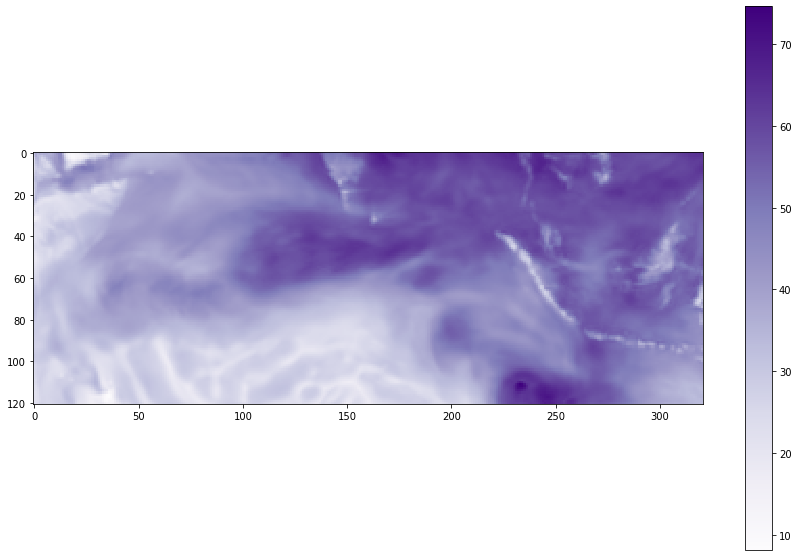

In [15]:
plt.figure(figsize=(15,10))
plt.imshow(PW.tcwv.sel({'time':'2016-08-28T00:00:00', 'latitude':slice(15,-15),'longitude':slice(40,120)}),cmap='Purples')
plt.colorbar()

In [16]:
def find_separation_bin(field,vmin=45,vmax=55,bins=100):
# Inputs
# field = field from which to take the pdf
# vmin = minimal value of the interval over which min(PDF) will be searched
# vmax = maximal value //
# bins = Number of bins of the PDF

    field_hist,bin_edges = np.histogram(field.flatten(),bins=bins)
    bin_mid = 0.5*(bin_edges[:-1]+bin_edges[1:])

    binary = (bin_mid<vmax)*(bin_mid>vmin)
    imin =  np.argmin(field_hist[binary])+np.argmax(binary)

    return bin_mid[imin],bin_mid

In [56]:
CWV_sep,bin_m = find_separation_bin(PW.tcwv[:,:,:].sel({'time':'2016', 'latitude':slice(15,-15),'longitude':slice(40,120)}).values)

45.08401536941528


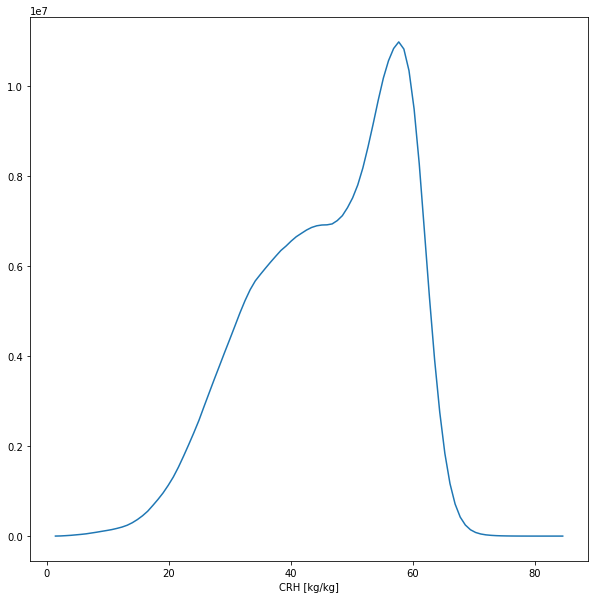

In [60]:
plt.figure(figsize=(10,10))
CWV_hist,bin_edges = np.histogram(PW.tcwv[:,:,:].sel({'time':'2016', 'latitude':slice(15,-15),'longitude':slice(40,120)}).values.flatten(),\
                                  bins=100)
bin_m = 0.5*(bin_edges[:-1]+bin_edges[1:])
plt.plot(bin_m,CWV_hist)
plt.xlabel('CRH [kg/kg]')

imin_tmp = np.argmin(CWV_hist[(bin_m<55)*(bin_m>45)])
ileft = np.argmax((bin_m<55)*(bin_m>45))
imin = ileft+imin_tmp
print(bin_m[imin])

CWV_sep = bin_m[imin]

# 1) Define WindMiller Index

In [34]:
# Average grid box area
Nx = PW.longitude.size
Ny = PW.latitude.size
A_earth = 510.1e6; # In km2
A_grid_avg = A_earth/(Nx*Ny)
dx_avg = np.sqrt(A_grid_avg)

In [35]:
def calc_WMI(CRH,dx,CRH_sep=None, slices=1):
    ### Input: precipitable water field (time, x, y)
    ### dx = Average grid spacing
    ### CRH_sep = Value separating moist and dry regions
    ### Returns: aggregation index calculated as 4*area*pi/(perimeter length)**2
    ###          which compares the length of the boundary between the moist and 
    ###          the dry region with the circumference of the moist region
    ###
    ### Option: slices, slice longitude into s slices and compute averge WMI over subregions
    
    assert slices > 0, 'slices needs to be at least 1'
    
    if CRH_sep==None: CRH_median = np.median(CRH, axis=(1,2))
    else: CRH_sep = np.expand_dims(CRH_sep,axis=0)
    print(CRH_sep.shape)
    tmp = np.repeat(CRH_sep[:, np.newaxis], CRH.shape[1], axis=1)
    CRH_median_rep = np.repeat(tmp[:,:,np.newaxis],CRH.shape[2],axis=2)
    
    binary = CRH>CRH_median_rep
    binary = binary.values #Convert to numpy array

    #split region into n slices, assume that longitude is last dimension
    #Todo, change axis to whatever longitude is
    binary=np.array_split(binary, slices, axis=2)
    binary=np.asarray(binary)
    
    A_tot = np.sum(binary,axis=(2,3))*(dx**2)/1e12
    perimeter_tot = np.zeros(CRH.shape[0])    

    for it in range(len(np.median(CRH,axis=(1,2)))):
        #print("calculating time step %i"%it)
        for s in range(slices):    
            perimeter_tot[it] = dx*(measure.perimeter(binary[s,it,:,:],8) - measure.perimeter(binary[s,it,:,1:-2])/2)/1e6

    WMI = np.mean(4*np.pi*A_tot/perimeter_tot**2, axis=0)

    
    return WMI

# 2) WindMiller Index for the Indian Ocean

In [59]:
WMI = calc_WMI(PW.tcwv[:,:,:].sel({'time':'2016', 'latitude':slice(15,-15),'longitude':slice(40,120)}),\
               dx_avg,CRH_sep=48)

(1,)


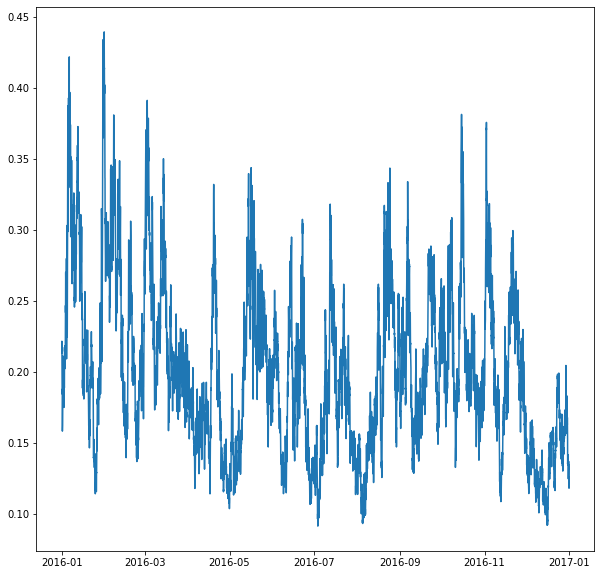

In [61]:
plt.figure(figsize=(10,10))
plt.plot(PW.time.sel({'time':'2016'}),WMI)

In [62]:
#T endency of Windmiller Index
dWMI = WMI[:-1] - WMI[1:]

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(dWMI, bins=20)
plt.xlabel('dWMI [1 / h]')
plt.xaxis(-0.04,0.04)